In [1]:
# ============================================================================
# INSTALLATION
# ============================================================================
!pip install transformers accelerate torch bertopic sentence-transformers scikit-learn pandas pyarrow hf-transfer seaborn

  Using cached transformers-4.57.1-py3-none-any.whl.metadata (43 kB)
  Using cached accelerate-1.11.0-py3-none-any.whl.metadata (19 kB)
  Using cached bertopic-0.17.3-py3-none-any.whl.metadata (24 kB)
  Using cached sentence_transformers-5.1.2-py3-none-any.whl.metadata (16 kB)
  Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached pyarrow-22.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.2 kB)
  Using cached hf_transfer-0.1.9-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.7 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached regex-2025.11.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (40 kB)
  Using cached tokenizers-0.22.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
  Us

In [33]:
# ============================================================================
# IMPORTS
# ============================================================================
import pandas as pd
import torch
import pyarrow.parquet as pq
from transformers import AutoTokenizer, AutoModel
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from IPython.display import display

# ============================================================================
# CUSTOM EMBEDDER
# ============================================================================
class CustomEmbedder:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
    
    def encode(self, texts, **kwargs):
        inputs = self.tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = self.model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1)
        return embeddings.cpu().numpy()

# ============================================================================
# MAIN ANALYSIS
# ============================================================================
# Load model
print("Loading model...")
MODEL_NAME = "nvidia/llama-embed-nemotron-8b"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
model = AutoModel.from_pretrained(MODEL_NAME, torch_dtype=torch.float16, device_map="auto", trust_remote_code=True)
print(f"✓ Loaded {MODEL_NAME}")

# Load data
print("\nLoading data...")
df = pq.read_table("export_articles_translated.parquet").to_pandas()
docs = df["content_english"].dropna().tolist()
print(f"✓ Loaded {len(docs)} documents")

# ============================================================================
# CONFIGURE UMAP AND HDBSCAN PARAMETERS
# ============================================================================
# UMAP parameters
umap_model = UMAP(
    n_neighbors=20,        # Default: 15. Higher = more global structure. Range: 2-100
    n_components=5,        # Default: 5. Number of dimensions to reduce to
    min_dist=0.0,          # Default: 0.1. Minimum distance between points. Range: 0.0-0.99
    metric='cosine',       # Distance metric: 'cosine', 'euclidean', etc.
    random_state=42        # For reproducibility
)

# HDBSCAN parameters
hdbscan_model = HDBSCAN(
    min_cluster_size=220,   # Default: 10. Minimum size of clusters. Increase for fewer, larger topics
    min_samples=15,         # Default: None. Higher = more conservative clustering
    metric='euclidean',    # Distance metric: 'euclidean', 'manhattan', etc.
    cluster_selection_method='eom',  # 'eom' or 'leaf'
    prediction_data=True   # Needed for transform
)

# Setup BERTopic
print("\nSetting up BERTopic...")
embedding_model = CustomEmbedder(model, tokenizer)
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
custom_stopwords = list(ENGLISH_STOP_WORDS) + ['said', 'efe']
vectorizer_model = CountVectorizer(stop_words=custom_stopwords)

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    verbose=True
)
print("✓ BERTopic configured")

# Run analysis
print("\nRunning topic modeling...")
topics, probs = topic_model.fit_transform(docs)

# Add topics to dataframe
df_clean = df.dropna(subset=["content_english"]).copy()
df_clean["topic"] = topics

# Display results
print(f"\n{'='*60}")
print(f"RESULTS: Found {len(set(topics))} topics")
print(f"{'='*60}\n")

# Show topic info
topic_info = topic_model.get_topic_info()
display(topic_info)

# Show sample of articles with topics
print(f"\n{'='*60}")
print("SAMPLE ARTICLES WITH TOPICS")
print(f"{'='*60}\n")
display(df_clean[["content_english", "topic"]].head(10))

# Optional: Save results (uncomment if needed)
# df_clean.to_parquet("articles_with_topics.parquet", index=False)
# topic_model.save("bertopic_model")
# print("\n✓ Saved to: articles_with_topics.parquet and bertopic_model/")

Loading model...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✓ Loaded nvidia/llama-embed-nemotron-8b

Loading data...


2025-11-16 10:54:30,422 - BERTopic - Embedding - Transforming documents to embeddings.


✓ Loaded 10881 documents

Setting up BERTopic...
✓ BERTopic configured

Running topic modeling...


Batches:   0%|          | 0/341 [00:00<?, ?it/s]

2025-11-16 10:54:50,210 - BERTopic - Embedding - Completed ✓
2025-11-16 10:54:50,212 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-16 10:55:01,169 - BERTopic - Dimensionality - Completed ✓
2025-11-16 10:55:01,171 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 10:55:01,430 - BERTopic - Cluster - Completed ✓
2025-11-16 10:55:01,434 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 10:55:03,653 - BERTopic - Representation - Completed ✓



RESULTS: Found 14 topics



,Topic,Count,Name,Representation,Representative_Docs
0,-1,2472,-1_da_la_switzerland_il,"[da, la, switzerland, il, people, swiss, accor...","[Switzerland aspires to ""human"" artificial int..."
1,0,1207,0_president_venezuela_drug_country,"[president, venezuela, drug, country, governme...",[U.S. President Donald Trump believes Nicolás ...
2,1,1055,1_switzerland_swiss_tax_initiative,"[switzerland, swiss, tax, initiative, federal,...",[November 30 vote: Swiss set to reject new inh...
3,2,1031,2_gaza_israeli_israel_hamas,"[gaza, israeli, israel, hamas, army, al, pales...",[Israel receives remains of another hostage fr...
4,3,793,3_team_league_match_goal,"[team, league, match, goal, game, minute, poin...",[Soccer - Baromètre des Romands Sion has found...
5,4,759,4_police_arrested_court_man,"[police, arrested, court, man, old, prosecutor...",[Two people are indicted for the Louvre robber...
6,5,691,5_film_music_new_time,"[film, music, new, time, media, years, la, peo...",[GR: 35th edition for Thusis World Film Days T...
7,6,597,6_billion_year_company_percent,"[billion, year, company, percent, market, sale...",[US Futures Rise on Tech Results After Downbea...
8,7,502,7_russian_nuclear_russia_ukraine,"[russian, nuclear, russia, ukraine, ukrainian,...","[Challenged by Moscow, Donald Trump orders res..."
9,8,485,8_trump_china_south_korea,"[trump, china, south, korea, xi, meeting, chin...",[Xi travels to South Korea for his meeting wit...



SAMPLE ARTICLES WITH TOPICS



,content_english,topic
0,"""Goodnight"" was a program of an independent ra...",5
1,Crime affects large Peruvian businessmen and b...,0
2,FinnLAC stresses that an efficient fintech eco...,12
3,Widow of murdered mayor in Mexico takes office...,0
4,Dominican Republic strengthens the competitive...,0
5,Snapchat's parent company announces $400 milli...,6
6,"Brazil, Colombia and Mexico dominate athletics...",3
7,Judge orders ICE to improve 'inhumane' conditi...,4
8,Asian Stocks Set to Rise After Wall Street Gai...,6
9,Copom keeps Selic rate at 15% The Central Bank...,12


In [36]:
# ============================================================================
# SAVE RESULTS TO CSV
# ============================================================================
# Add topic labels to the dataframe
print("\nPreparing data for export...")

# Define your custom topic labels
custom_topic_labels = {
    -1: "Outliers / Unassigned",
    0: "Latin American Politics",
    1: "Swiss Domestic Affairs",
    2: "Africa & Middle East",
    3: "International Sports News",
    4: "Law, Crime, Public Safety",
    5: "Arts & Culture",
    6: "Business & Economics",
    7: "International Security & Military Affairs",
    8: "International Trade & Geopolitics",
    9: "Natural Disaster & Humanitarian Response",
    10: "US Domestic Affairs",
    11: "Climate Action & Policy",
    12: "Business & Economics in Latin America"
}

# Map topics to custom labels
df_clean['topic_label'] = df_clean['topic'].map(custom_topic_labels)

# Save all articles with topics
output_file = "articles_with_topics.csv"
df_clean.to_csv(output_file, index=False, encoding='utf-8')
print(f"✓ Saved all articles to: {output_file}")


Preparing data for export...
✓ Saved all articles to: articles_with_topics.csv


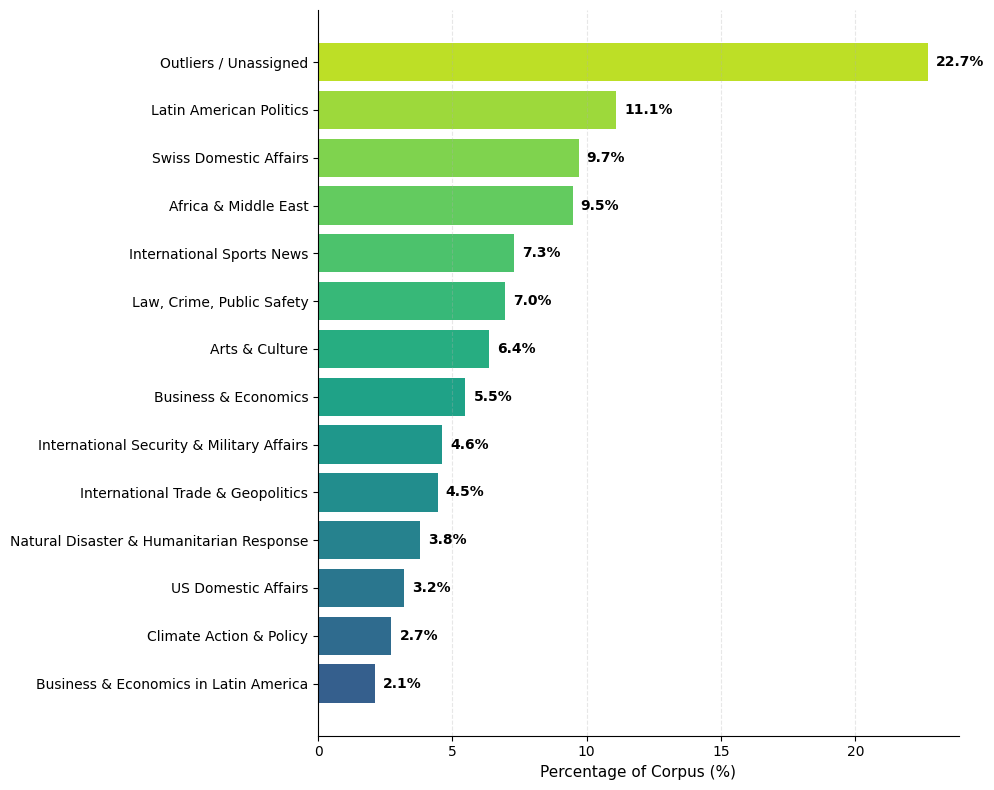

✓ Saved chart to: topic_distribution.png


In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate topic percentages
topic_counts = df_clean['topic_label'].value_counts()
topic_percentages = (topic_counts / len(df_clean) * 100).sort_values(ascending=True)

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 8))

# Use a nice color palette (viridis, but you can try: 'plasma', 'cividis', 'coolwarm')
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(topic_percentages)))

bars = ax.barh(topic_percentages.index, topic_percentages.values, color=colors)

# Add bar labels
for i, (bar, value) in enumerate(zip(bars, topic_percentages.values)):
    ax.text(value + 0.3, i, f'{value:.1f}%', 
            va='center', fontsize=10, fontweight='bold')

# Minimal styling
ax.set_xlabel('Percentage of Corpus (%)', fontsize=11)
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('topic_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved chart to: topic_distribution.png")

Loading data...
✓ Loaded 10881 articles
Date range: 2012-12-11 20:46:13 to 2025-11-05 23:58:57

Creating compact small multiples chart...
✓ Saved: topics_over_time_small_multiples.png


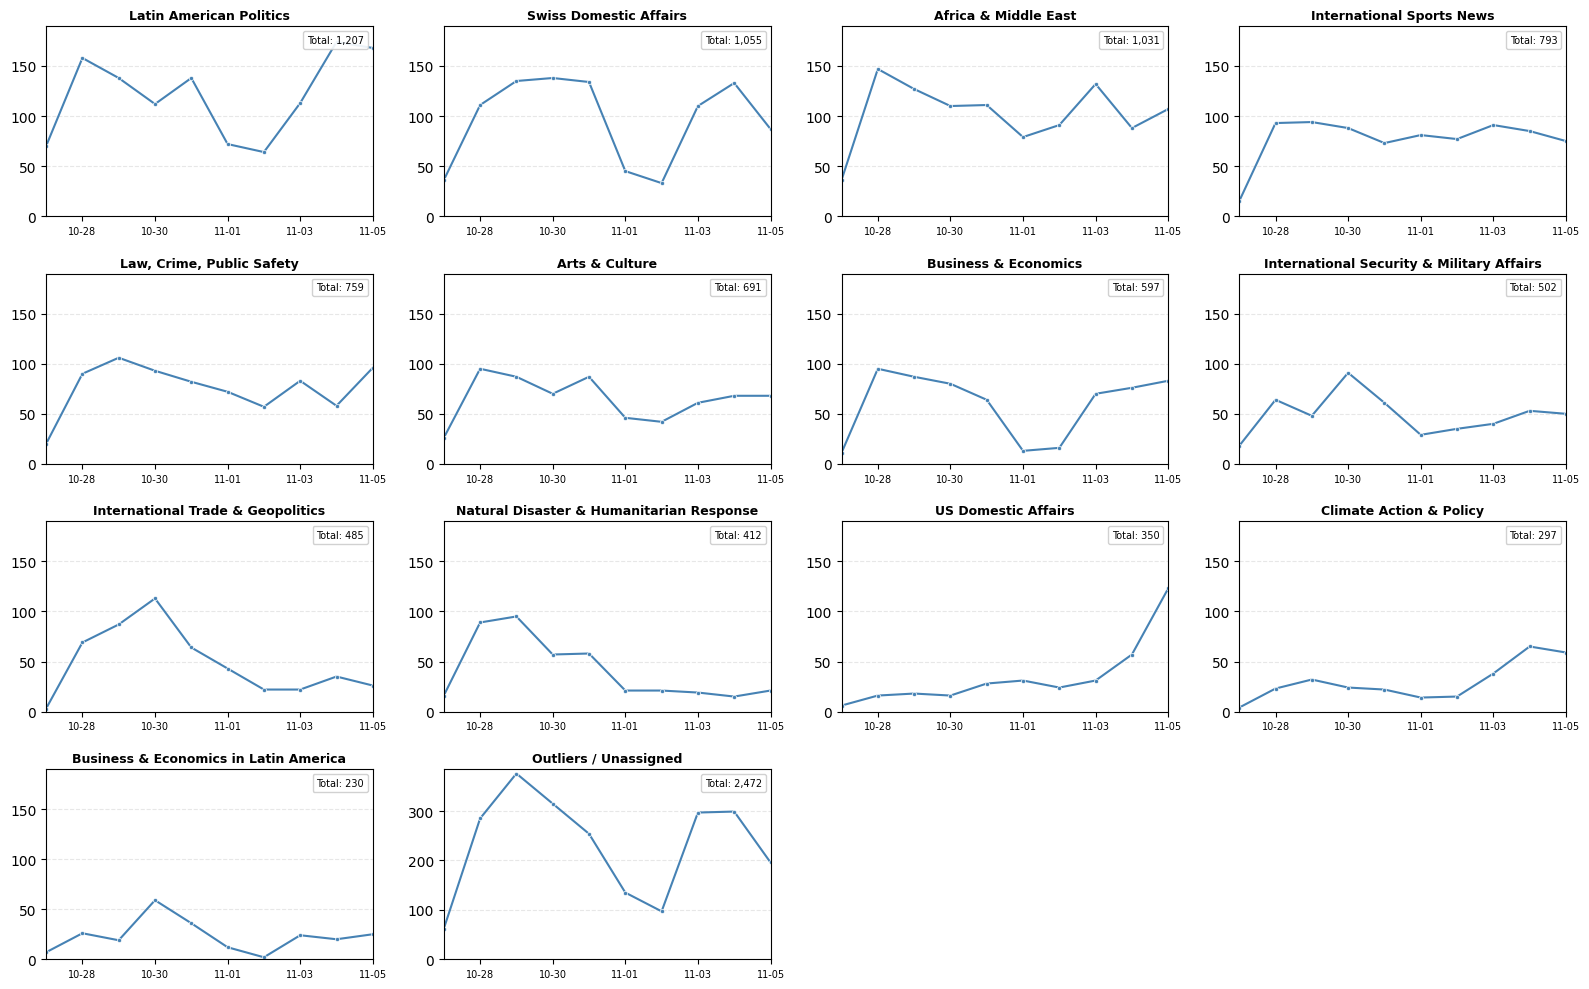

In [76]:
# ============================================================================
# TOPIC COUNTS OVER TIME - SMALL MULTIPLES (COMPACT)
# ============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# ============================================================================
# LOAD DATA
# ============================================================================
print("Loading data...")
df = pd.read_csv("articles_with_topics.csv")
print(f"✓ Loaded {len(df)} articles")

# Parse dates
df['releaseDate'] = pd.to_datetime(df['releaseDate'])
df['date'] = df['releaseDate'].dt.date
print(f"Date range: {df['releaseDate'].min()} to {df['releaseDate'].max()}")

# Set date limits for x-axis
date_min = datetime(2025, 10, 27)
date_max = datetime(2025, 11, 5)

# ============================================================================
# PREPARE DATA
# ============================================================================
# Calculate total counts per topic
topic_totals = df.groupby('topic_label').size().reset_index(name='total')
topic_totals = topic_totals.sort_values('total', ascending=False)

# Separate outliers from other topics
outliers_mask = topic_totals['topic_label'] == 'Outliers / Unassigned'
outliers_topic = topic_totals[outliers_mask]['topic_label'].tolist()
other_topics = topic_totals[~outliers_mask]['topic_label'].tolist()

# Combine: sorted topics + outliers at the end
topics = other_topics + outliers_topic

daily_counts = df.groupby(['topic_label', 'date']).size().reset_index(name='count')

# ============================================================================
# CREATE SMALL MULTIPLES (COMPACT)
# ============================================================================
print("\nCreating compact small multiples chart...")
n_topics = len(topics)
n_cols = 4  # More columns = more compact
n_rows = (n_topics + n_cols - 1) // n_cols

# Reduced figure size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 2.5*n_rows))
axes = axes.flatten() if n_rows > 1 else axes

for idx, topic in enumerate(topics):
    ax = axes[idx]
    
    topic_data = daily_counts[daily_counts['topic_label'] == topic].copy()
    topic_data = topic_data.sort_values('date')
    topic_data['date'] = pd.to_datetime(topic_data['date'])
    
    # Calculate total
    total = topic_data['count'].sum()
    
    # Plot with label for legend
    ax.plot(topic_data['date'], topic_data['count'], 
            color='steelblue', linewidth=1.5, marker='o', markersize=3, 
            markerfacecolor='steelblue', markeredgecolor='white', markeredgewidth=0.5,
            label=f'Total: {total:,}')
    
    # Smaller title with less padding
    ax.set_title(topic, fontsize=9, fontweight='bold', pad=5)
    
    if topic == 'Outliers / Unassigned':
        ax.set_ylim(0, 385)
    else:
        ax.set_ylim(0, 190)
    
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Format x-axis
    ax.set_xlim(date_min, date_max)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))  # Shorter date format
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), fontsize=7)
    
    # Add legend (text only, no marker or line)
    ax.legend(loc='upper right', fontsize=7, framealpha=0.9, handlelength=0, handletextpad=0, markerscale=0)

for idx in range(n_topics, len(axes)):
    axes[idx].axis('off')

plt.tight_layout(h_pad=1.5, w_pad=1.5)
plt.savefig('topics_over_time_small_multiples.png', dpi=300, bbox_inches='tight')
print("✓ Saved: topics_over_time_small_multiples.png")
plt.show()
plt.close()